# Setup

In [1]:
%%capture
!pip show transformers
!pip show accelerate
!pip install transformers[torch] -U
!pip install accelerate -U
!pip install transformers
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade transformers
!pip install datasets
!pip install gdown

# Preprocessing <nr> 
Note: Code downloads dataset, no need to have it on hand.

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import gdown


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

#The data format, combined with a whole new dataset format update makes for really terrible processing headaches
#That said, I'm redoing the whole dataset separation from the original dataset.

file_id = '1E5v6t-y2Pzeyi5C-amlYibp2cXUN0MLW'
url = f'https://drive.google.com/uc?id={file_id}'
file_path = 'all_data.csv'
if not os.path.exists(file_path):
    # Download the file
    gdown.download(url, file_path, quiet=False)

# Read the csv file
all_data = pd.read_csv(file_path, engine='python')

from sklearn.model_selection import train_test_split
toxicity_train_df, toxicity_test_df = train_test_split(all_data, test_size=0.40, random_state=42)

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.33 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.33).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.33).any(axis=1).astype(float)

# Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

# Can be adjusted to downsample training data
sample_rate = 1.0

toxicity_train_df = toxicity_train_df.sample(frac=sample_rate, random_state=42)

print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

Toxic train examples
                                              comment_text  toxic  obscene  \
680779   I commented on this last week on the Kiszla st...    0.0      0.0   
465571   We should store all illegals in truck bodies t...    1.0      0.0   
1710822  You're beginning to sound like Saddam's spokes...    0.0      0.0   
1727503  Weird comment. If the environmentalists caused...    0.0      0.0   

         sexual_explicit   threat    insult  identity_attack  
680779               0.0  0.00000  0.000000           0.0000  
465571               0.0  0.21875  0.140625           0.4375  
1710822              0.0  0.00000  0.200000           0.0000  
1727503              0.0  0.00000  0.000000           0.0000  
Toxic test examples
                                              comment_text  toxic  obscene  \
1610665  Naturally you can feel it in your urine. \nTha...    0.0      0.0   
495126   Yum!  What's not to love: water+maple syrup - ...    0.0      0.0   
431396   Catou I wi

Test Lengths of DFs

In [3]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

1199709
799807


# Visualization of toxicity in train

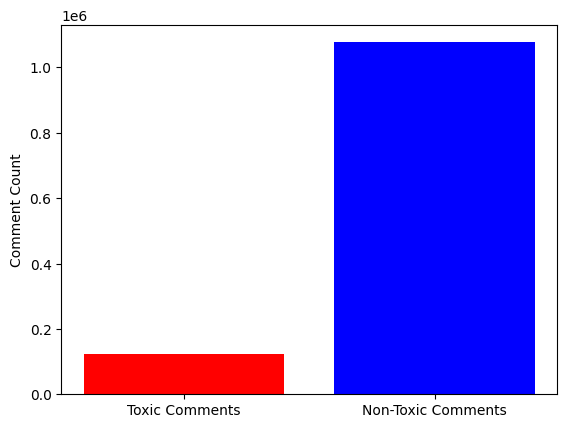

In [4]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

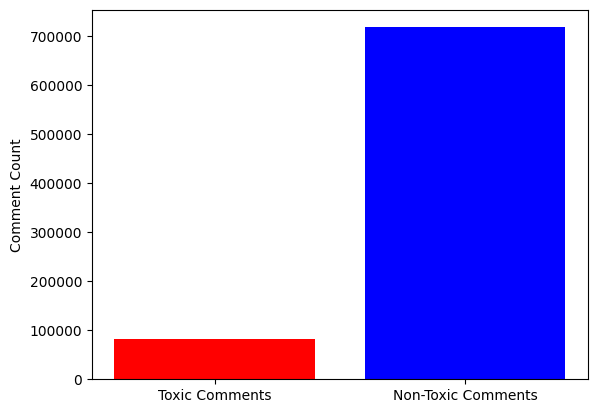

In [5]:
# Count toxic and non-toxic comments
toxic_count = toxicity_test_df['toxic'].sum()
non_toxic_count = len(toxicity_test_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Splitting and Labelling

In [6]:
model_name = "google/electra-small-discriminator"

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'toxic']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['toxic'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


train_texts:
["I commented on this last week on the Kiszla story of Dennison going to be a factor. Not only was he a factor, but the refs and home field was something Denver didn't handle well at all. The games aren't fixed but the refs are instructed to keep things close I am certain. Winning on the road is something that takes discipline and focus. They'll learn but it sucks to watch it happen.", 'We should store all illegals in truck bodies then ask them if they are ready to return to Mexico.', "You're beginning to sound like Saddam's spokesman Chemical Ali...", 'Weird comment. If the environmentalists caused the contaminations you might have a point.', 'canadian patriot writes:\n\n"KGB bloggers are sure trying hard to make Pukin a silk purse from a sow\'s ear. \n\nEven a face lift and elevator shoes cannot hide a Slav thug."\n\nAnd Naddaway gives patriot\'s post a "Disagree" vote.\n\nNaddaway postulates that a face lift and elevator shoes can, indeed, after all, hide a slavic thug.

# Training the Naive Bayes Model

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import pickle

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(train_texts, train_labels)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

Testing the fine tuned model on the dataset

In [8]:
import pandas as pd
import numpy as np
import random
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)

# Create and train the pipeline
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(train_texts, train_labels)

global count
global sub_mention
sub_mention = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    text_to_predict = text_to_predict.lower()
    probabilities = model.predict_proba([text_to_predict])[0]
    binary_label = 1 if (np.abs(probabilities[0]) < 0.976312776) else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)
    return binary_label, probabilities[0]

# Load the Twitch dataset
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Convert all string values in the DataFrame to lowercase
twitch_df = twitch_df.applymap(lambda s:s.lower() if type(s) == str else s)

# Apply the prediction function to each row in the DataFrame
nb_df = twitch_df.apply(predict_label, axis=1, result_type='expand')

Total length of test: 10002
it's not hard class, but don't expect the 4.0. she isn't clear about what is expected and the syllabus changed multiple times over the quarter. you can tell she doesn't take business students seriously and makes you feel awkward about your responses which really discourages participation.
0.9852732847862548
0
syllabus was clear on what the daily homework was, which was a huge help for the quarter! would recommend uploading her powerpoint presentations before her class to stay keep up with lectures; what she says verbally shows up on the midterms! also reading the textbook helped!! overall, good professor but her lectures are a bore.
0.9712298090069792
1
bridge is the coolest prof i've ever had. his joy and passion of the subjects he teaches is next level. he's always telling stories that relate to the subject in interesting ways. easy grader and really cares that the students fully understand, and succeed in his course. clear and fair expectations, do the ho

In [9]:
!pip install openpyxl
# Define the file path for the Excel file
excel_file_path = "naivebayes_UWBR_predictions.csv"

# Save the 'roberta_wiki_prediction' column to an Excel file
out_df = pd.DataFrame()
out_df['NaiveBayes_UWBR_predictions'], out_df['NaiveBayes_UWBR_probabilities'] = nb_df[0], nb_df[1]
out_df.to_csv(excel_file_path, index=False)